<h1><b>MODELLING STUDENT CITIES</b></h1>

The goal of this project is to examine differences between universities in the north and south of England based on types of venue.

First, we import the relevant modules.

In [1]:
import pandas as pd
import json
import requests # library to handle requests
import math

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import numpy as np

import pylab

Next, we enter our Foursquare API credentials.

In [2]:
#foursquare api credentials
CLIENT_ID = ''
CLIENT_SECRET = '' 
VERSION = '' # Foursquare API version

For ease of programming we now define a series of functions that will streamline the process of getting venues for each university.

<i>getNearbyVenues</i> will return the venues within a given radius of a set of coordinates.

In [3]:
#define useful functions

def getNearbyVenues(names, lat, lng, radius=3000,LIMIT=500):
    
    venues_list=[]
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
            
        # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
    venues_list.append([(
        names, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['id'],
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 'Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

A problem with <i>getNearbyVenues</i> is that it will only return 100 venues - for large areas this isn't ideal. What we can do is generate a series of points around and close to the university, so we can sample more venues in each neighbourhood, using the function <i>geocircle</i>:

In [4]:
#create a circle of points from which to calculate a large number of venues
#geopy has a function that does this but it has a history of distance issues


def geocircle(d, phi, lat, lng, R = 6378.1):
    
    phi = math.radians(phi)
    
    lng_1 = math.radians(lng) #convert lat and long to radians
    lat_1 = math.radians(lat)
 
    lat_2 = math.asin(math.sin(lat_1)*math.cos(d/R) + 
                     math.cos(lat_1)*math.sin(d/R)*math.cos(phi))

    lng_2 = lng_1 + math.atan2(math.sin(phi)*math.sin(d/R)*
                              math.cos(lat_1),math.cos(d/R)
                              -math.sin(lat_1)*math.sin(lat_2))
    
    lat_2 = math.degrees(lat_2)
    lng_2 = math.degrees(lng_2)
    
    return lat_2, lng_2

Bringing these two functions together, our last step is remove venues that have been counted multiple times. We combine these steps in the function <i>get_venues</i>:

In [5]:
def get_venues(city,city_points):
    city_venues = pd.DataFrame() #create empty dataframe

    for lt, lg in city_points[0]: #for each point around the university

        city_venues = city_venues.append(getNearbyVenues(names = city,
                                       lat= lt,
                                       lng= lg
                                      )) #get venues




    city_venues.drop_duplicates('Venue ID',inplace=True) #and drop duplicates

    return city_venues

<i>get_grouped</i> will onehot encode and normalize the list of venues for each university for ease of analysis by the clustering function.

In [6]:
def get_grouped(city_venues):
    city_onehot = pd.get_dummies(city_venues[['Venue Category']],prefix="",prefix_sep="")
    city_onehot['City'] = city_venues['City']
    
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]
    
    city_grouped = city_onehot.groupby('City').mean().reset_index()
    
    return city_grouped

<i>return_most_common_venues</i> will return the top ten venues for each university for ease of analysis by us!

In [7]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    #return row_categories_sorted.index.values[0:num_top_venues]
    return row_categories_sorted.index.values[0:num_top_venues]

Finally, we'll bring it all together in the function <i>get_top_venues</i>:

In [8]:
def get_top_venues(city, lat,lng):
    
    city_points=[] #empty list

    bearings = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0] #bearings in degrees: north, northeast, east, southeast, south...etc

    city_points.append([geocircle(3.0, p, lat, lng) for p in bearings]) #now generate points along these bearings for each university
    
    city_venues = get_venues(city,city_points) #and get the venues around each of these points!
    
    city_grouped = get_grouped(city_venues) #onehot encoding
    
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['City']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1)) 

    # create a new dataframe
    city_venues_sorted = pd.DataFrame(columns=columns)
    city_venues_sorted['City'] = city_grouped['City']

    for ind in np.arange(city_grouped.shape[0]):
        city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues) #get the top ten venues

    n=10
    
    #create another new dataframe:
    city_venues_frequency = city_venues['Venue Category'].value_counts()[:n].rename_axis('Venue Category').reset_index(name='Counts')

    for ind in (np.arange(num_top_venues)+1):
        try:
            city_venues_sorted.insert(2*ind,'{}{} Venue Frequency'.format(ind,indicators[ind-1]),city_venues_frequency['Counts'][ind-1])
        except:
            city_venues_sorted.insert(2*ind,'{}th Venue Frequency'.format(ind),city_venues_frequency['Counts'][ind-1])

        
    city_venues_sorted['Unique Categories'] =  len(city_venues['Venue Category'].unique())
    city_venues_sorted['Total Venues'] = len(city_venues['Venue Category'])         

    return city_venues_sorted,city_grouped


We're ready to begin analysis. The university.csv has a list of thirty universities with coordinates:

In [9]:
universities = pd.read_csv('university.csv')
universities.dropna(inplace=True)

universities.head()

,REGION,UNIVERSITY,LATITUDE,LONGITUDE
0,SOUTH ENGLAND,University of Oxford,51.7548,-1.2544
1,SOUTH ENGLAND,University of Southampton,50.9351,-1.3958
2,SOUTH ENGLAND,University of Sussex,50.8671,-0.0879
3,SOUTH ENGLAND,University of Reading,51.4414,-0.9418
4,SOUTH ENGLAND,University of Cambridge,52.2043,0.1149


Now we get venues for each of these universities:

In [10]:
universities_full = pd.DataFrame()
universities_grouped = pd.DataFrame()

for name, latitude, longitude in zip(universities['UNIVERSITY'][20:], universities['LATITUDE'][20:],universities['LONGITUDE'][20:]):
    print(name)
    universities_full, universities_grouped = universities_full.append(get_top_venues(name, latitude, longitude)[0]), universities_grouped.append(get_top_venues(name,latitude,longitude)[1])

This is quite a long process. Luckily I did it earlier and created csvs that we can read from instead of doing it again:

In [10]:
universities_grouped = pd.read_csv('university_grouped_full_1.csv')
universities_grouped.drop(universities_grouped.columns[[0]],axis=1,inplace=True)

universities_full = pd.read_csv('university_venues_full.csv')
universities_full.drop(universities_full.columns[[0]],axis=1,inplace=True)

In [11]:
universities_full.head()

,City,1st Most Common Venue,1st Venue Frequency,2nd Most Common Venue,2nd Venue Frequency,3rd Most Common Venue,3rd Venue Frequency,4th Most Common Venue,4th Venue Frequency,5th Most Common Venue,...,7th Most Common Venue,7th Venue Frequency,8th Most Common Venue,8th Venue Frequency,9th Most Common Venue,9th Venue Frequency,10th Most Common Venue,10th Venue Frequency,Unique Categories,Total Venues
0,University of Oxford,Pub,42,Hotel,15,Grocery Store,13,Coffee Shop,11,Café,...,Supermarket,8,Chinese Restaurant,7,Bakery,7,Restaurant,7,102,279
1,University of Southampton,Grocery Store,41,Pub,35,Coffee Shop,22,Supermarket,13,Fast Food Restaurant,...,Pizza Place,9,Hotel,8,Bar,7,Italian Restaurant,7,93,314
2,University of Sussex,Pub,15,Café,13,Coffee Shop,13,Park,9,Grocery Store,...,Pizza Place,3,Gastropub,3,Indian Restaurant,3,Bakery,3,66,139
3,University of Reading,Pub,35,Grocery Store,16,Coffee Shop,14,Hotel,12,Supermarket,...,Clothing Store,8,Café,8,Gym / Fitness Center,7,Park,7,104,290
4,University of Cambridge,Pub,39,Coffee Shop,13,Café,12,Grocery Store,11,Hotel,...,Gastropub,7,Burger Joint,6,Supermarket,6,Gym / Fitness Center,6,84,238


Let's look at these universities on the map.

In [12]:
map_large = folium.Map(location=[52.8555, -1.1743], zoom_start=6)

for name, lt, lg in zip(universities['UNIVERSITY'],universities['LATITUDE'],universities['LONGITUDE']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lt, lg],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#800020',
        fill_opacity=0.7,
        parse_html=False).add_to(map_large) 
    
map_large

One more function to define. How do we know which number of clusters is optimal? The elbow method and the silhouette score can be used in tandem to confirm the optimal K. See the report for more details.

In [26]:
from sklearn.metrics import silhouette_score
pylab.rcParams["font.family"] = "Times New Roman"
#elbow method

def kmean_optimize(points,kmax,ins='random',itrs=12,rs=1,plot='yes',save='no'):
    
    sse = []
    sil = []
    k_values = np.arange(2,kmax+1,1)
    
    
    for k in range(2,kmax+1):
        k_means = KMeans(n_clusters=k,random_state=rs).fit(points)
        
        #elbow method
            
        sse.append(k_means.inertia_)
        
        #silhouette method
        
        labels = k_means.labels_
        score = silhouette_score(points, labels, metric = 'euclidean')
        sil.append(score)
        
        
    if plot == 'yes':
        
        #plot k vs sse
        #pylab.subplot(2,1,1)
        pylab.plot(k_values,sse,color='blue')
        pylab.title('Inertia vs. Number of Clusters',size=20,weight='bold')
        pylab.ylabel('Inertia',size=15)
        pylab.xlabel('Number of Clusters K',size=15)
        pylab.yticks(np.arange(0,62,step=10))
        pylab.grid(True)
        if save !='no': pylab.savefig('Inertia.png',dpi=1000)
        
        
        pylab.show()
        #plot k vs sil
        #pylab.subplot(2,1,2)
        pylab.plot(k_values,sil,color='red')
        pylab.title('Silhouette Score vs. Number of Clusters', size=20,weight='bold')
        pylab.xlabel('Number of Clusters K', size=15)
        pylab.ylabel('Silhouette Score', size=15)
        pylab.yticks(np.arange(0.5,1.0,step=0.1))
        pylab.grid(True)
        if save != 'no':pylab.savefig('Silhouette Score.png', dpi=1000)
        
        if save != 'no':
            pylab.savefig(save, dpi = 1000)
        
    
        pylab.show()
    
    return sse, sil, np.argmax(b)+2

In [27]:
universities_grouped = universities_grouped.fillna(0)

universities_grouped_clustering = universities_grouped.drop('City', 1)

Alright, let's see what we have:

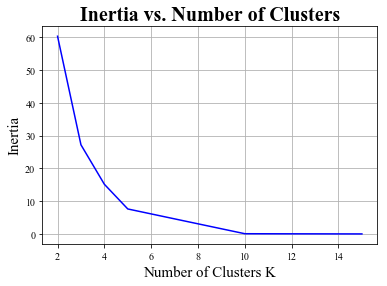

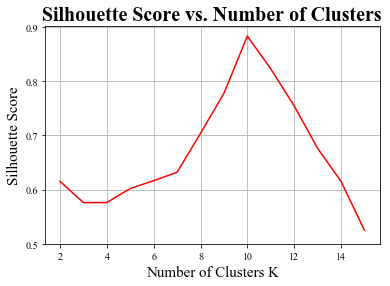

In [28]:
a,b,c= kmean_optimize(universities_grouped_clustering,15)

In [25]:
c

10

The best k is shown to be k =10. Now let's run kmeans with this number!

In [16]:
# set number of clusters
kclusters = 10

# run k-means clustering
k_means = KMeans(n_clusters=kclusters,init='random', n_init=1, random_state=100).fit(universities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
k_means.labels_[0:10] 

array([5, 5, 5, 3, 4, 7, 8, 6, 2, 0])

In [17]:
universities.rename(columns={'UNIVERSITY':'City'},inplace=True)

# add clustering labels
universities_full.insert(0, 'Cluster Labels', k_means.labels_)

universities_merged = universities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
universities_merged = universities_merged.join(universities_full.set_index('City'), on='City')

universities_merged.head() # check the last columns!

,REGION,City,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,1st Venue Frequency,2nd Most Common Venue,2nd Venue Frequency,3rd Most Common Venue,...,7th Most Common Venue,7th Venue Frequency,8th Most Common Venue,8th Venue Frequency,9th Most Common Venue,9th Venue Frequency,10th Most Common Venue,10th Venue Frequency,Unique Categories,Total Venues
0,SOUTH ENGLAND,University of Oxford,51.7548,-1.2544,5,Pub,42,Hotel,15,Grocery Store,...,Supermarket,8,Chinese Restaurant,7,Bakery,7,Restaurant,7,102,279
1,SOUTH ENGLAND,University of Southampton,50.9351,-1.3958,5,Grocery Store,41,Pub,35,Coffee Shop,...,Pizza Place,9,Hotel,8,Bar,7,Italian Restaurant,7,93,314
2,SOUTH ENGLAND,University of Sussex,50.8671,-0.0879,5,Pub,15,Café,13,Coffee Shop,...,Pizza Place,3,Gastropub,3,Indian Restaurant,3,Bakery,3,66,139
3,SOUTH ENGLAND,University of Reading,51.4414,-0.9418,3,Pub,35,Grocery Store,16,Coffee Shop,...,Clothing Store,8,Café,8,Gym / Fitness Center,7,Park,7,104,290
4,SOUTH ENGLAND,University of Cambridge,52.2043,0.1149,4,Pub,39,Coffee Shop,13,Café,...,Gastropub,7,Burger Joint,6,Supermarket,6,Gym / Fitness Center,6,84,238


Finally, let's look at our results on the map:

In [18]:
# create map
map_clusters = folium.Map(location=[52.8555, -1.1743], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(universities_merged['LATITUDE'], universities_merged['LONGITUDE'], universities_merged['City'], universities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters